In [5]:
import ee
import geemap
from geemap import chart

%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
ee.Initialize()

In [7]:
ls8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
modis = ee.ImageCollection("MODIS/006/MOD13Q1")
modisOther = ee.ImageCollection("MODIS/006/MCD43A4")
focus = ee.Geometry.Polygon(
        [[[27.350233348102517, -7.518171474050515],
          [27.350233348102517, -7.57841301205225],
          [27.436407359332986, -7.57841301205225],
          [27.436407359332986, -7.518171474050515]]])
TailingPonds = ee.Geometry.MultiPolygon(
        [[[[27.40117714611331, -7.528029420400128],
           [27.40143463817874, -7.529901416251066],
           [27.40237877575198, -7.5338155632667805],
           [27.404009558833035, -7.535347176386731],
           [27.403837897456082, -7.531603223645428],
           [27.402807929194363, -7.53075232078353],
           [27.402464606440457, -7.527518874674277]]],
         [[[27.401692130244168, -7.537219140622778],
           [27.40160629955569, -7.538835830496198],
           [27.402207114375027, -7.539516540215821],
           [27.40564034191409, -7.539091096766489],
           [27.40564034191409, -7.538410386377943]]],
         [[[27.38813088146487, -7.548791103460967],
           [27.38890335766116, -7.549046363857512],
           [27.391821601069363, -7.5484507560311345],
           [27.389761664545926, -7.546749014863657]]]])
WestMine = ee.Geometry.Polygon(
        [[[27.358738291876765, -7.561662590595413],
          [27.36234318079278, -7.564044944105011],
          [27.370411265509578, -7.545155923172768],
          [27.363201487677546, -7.53885939945966],
          [27.35564838709161, -7.542262937167664]]])
EastMine = ee.Geometry.Polygon(
        [[[27.40010868372247, -7.521416293051669],
          [27.400966990607234, -7.534520294117901],
          [27.381225932257625, -7.552729091874256],
          [27.384659159796687, -7.55426063803815],
          [27.40457187952325, -7.542008116801026],
          [27.406975138800593, -7.53877475471045],
          [27.40285526575372, -7.521586477421349]]])

rgbVis = {
    'min': 8097.96,
    'max': 12128.04,
    'bands': ['SR_B4', 'SR_B3', 'SR_B2']
}
ndviVis = {
  'min': 0.0,
  'max': 8000.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ]
}

In [8]:
def create_median_composites(geometry, start, end):
    images = []
    
    for year in range(start, end+1):
        filtered = ls8 \
            .filter(ee.Filter.bounds(geometry)) \
            .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
            .filter(ee.Filter.lt('CLOUD_COVER', 15)) \
            .select('SR_B.*') \

        composite = filtered.median().clip(geometry)
        
        images.append((composite, year))
        
    return images

def add_median_composites(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 13)
    
    for image, year in images:
        Map.addLayer(image, rgbVis, str(year) + ' Median Composite')
        
    return Map
images = create_median_composites(focus, 2014, 2020)
Map = add_median_composites(images, focus)
Map

Map(center=[-7.548293653363665, 27.393320353717858], controls=(WidgetControl(options=['position', 'transparent…

In [9]:
def create_ndvi_layers(start, end, geometry):
    images = []
    
    for year in range(start, end):
        ndvi = modis \
                .filter(ee.Filter.bounds(geometry))\
                .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
                .select('NDVI') \
                .median() \
                .clip(geometry)
        
        images.append((ndvi, year))
        
    return images

In [10]:
def add_ndvi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        Map.addLayer(image, ndviVis, 'NDVI ' + str(year))
        
    return Map

In [11]:
Map = add_ndvi_layers(create_ndvi_layers(2004, 2020, WestMine), WestMine)
Map

KeyboardInterrupt: 

In [ ]:
Map = add_ndvi_layers(create_ndvi_layers(2004, 2020, EastMine), EastMine)
Map

In [12]:
def extract_data(image):
    stats = image.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': image.geometry(),
        'scale': 10
    })
    
    properties = {
        'Year': image.get('system:index'),
        'NDVI': stats.get('NDVI'),
    }
    return ee.Feature(None, properties)

   Year         NDVI
0     0  7150.943612
1     1  6689.711373
2     2  6426.426952
3     3  7042.484156
4     4  6709.760274
5     5  6400.212005
6     6  6957.013665
7     7  6749.060895
8     8  6728.693749
9     9  6973.720544
10   10  6672.886133
11   11  6437.235540
12   12  6766.502552
13   13  6880.463641
14   14  6820.663773
15   15  6149.689022


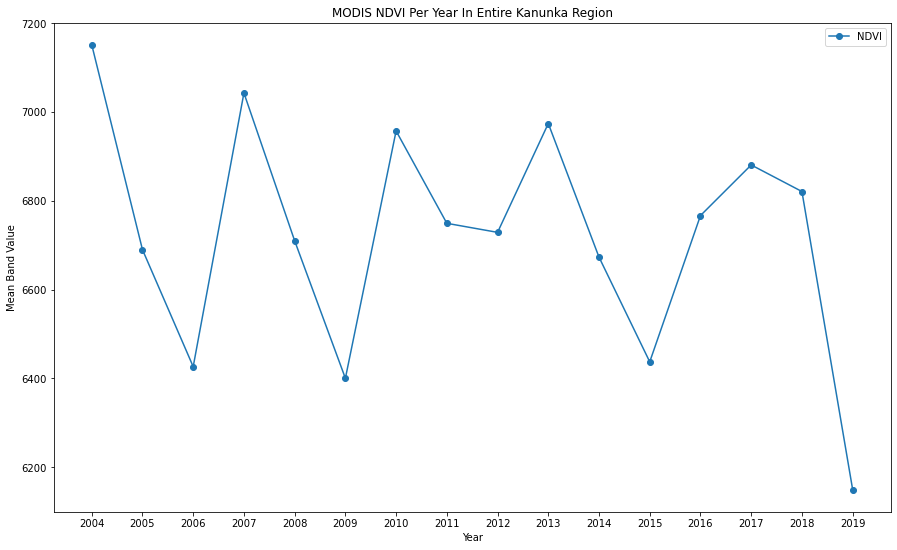

In [14]:
images = ee.ImageCollection(create_ndvi_layers(2004, 2020, focus))
#with_ndvi = images.map(add_ndvi)
data = ee.FeatureCollection(images.map(extract_data))
df = geemap.ee_to_pandas(data)
images = create_ndvi_layers(2004, 2020, focus)
print(df)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 9)

xticks = [t[1] for t in images]
ax.set_xticks([i for i in range(16)], xticks)

df.plot(ax=ax,
       title = 'MODIS NDVI Per Year In Entire Kanunka Region',
       xlabel='Year',
       ylabel='Mean Band Value',
       marker='o')

plt.show()

   Year         NDVI
0     0  7339.000632
1     1  6935.583343
2     2  6701.434346
3     3  7231.198532
4     4  6888.620389
5     5  6751.743139
6     6  7184.282030
7     7  7218.525472
8     8  6671.612649
9     9  7161.232293
10   10  6748.835179
11   11  5837.348111
12   12  5922.050350
13   13  6032.238086
14   14  6225.218421
15   15  5118.540172


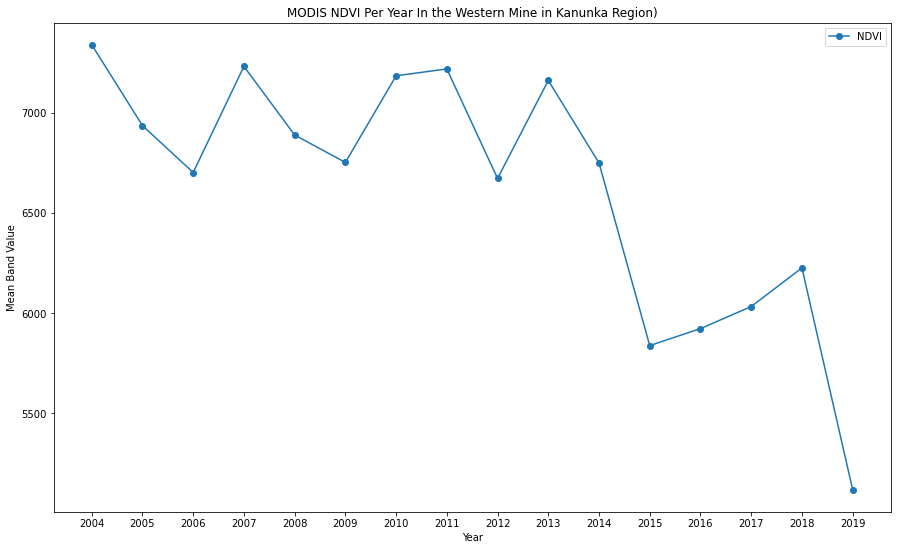

In [15]:
images = ee.ImageCollection(create_ndvi_layers(2004, 2020, WestMine))
#with_ndvi = images.map(add_ndvi)
data = ee.FeatureCollection(images.map(extract_data))
df = geemap.ee_to_pandas(data)
images = create_ndvi_layers(2004, 2020, WestMine)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 9)

xticks = [t[1] for t in images]
ax.set_xticks([i for i in range(16)], xticks)
print(df)
df.plot(ax=ax,
       title = 'MODIS NDVI Per Year In the Western Mine in Kanunka Region)',
       xlabel='Year',
       ylabel='Mean Band Value',
       marker='o')

plt.show()

   Year         NDVI
0     0  6553.429321
1     1  6008.285798
2     2  5844.584426
3     3  6228.827906
4     4  5844.173774
5     5  5756.464752
6     6  5875.890015
7     7  5619.012998
8     8  5812.064940
9     9  5503.350829
10   10  4816.863111
11   11  4496.086977
12   12  4604.671649
13   13  4366.393603
14   14  4014.949278
15   15  3547.745855


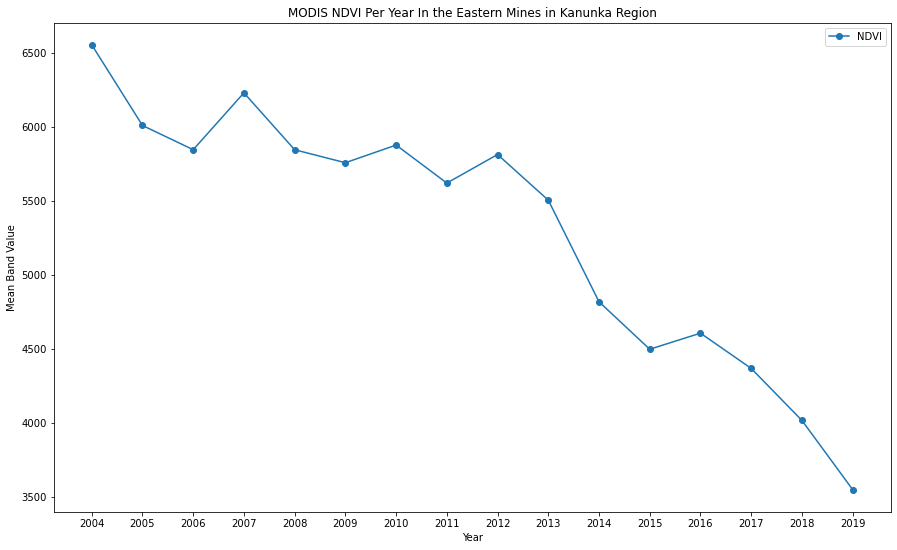

In [16]:
images = ee.ImageCollection(create_ndvi_layers(2004, 2020, EastMine))
#with_ndvi = images.map(add_ndvi)
data = ee.FeatureCollection(images.map(extract_data))
df = geemap.ee_to_pandas(data)
images = create_ndvi_layers(2004, 2020, EastMine)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 9)

xticks = [t[1] for t in images]
ax.set_xticks([i for i in range(16)], xticks)
print(df)
df.plot(ax=ax,
       title = 'MODIS NDVI Per Year In the Eastern Mines in Kanunka Region',
       xlabel='Year',
       ylabel='Mean Band Value',
       marker='o')

plt.show()

In [ ]:
images = ee.ImageCollection(create_ndvi_layers(2004, 2020, T))
#with_ndvi = images.map(add_ndvi)
data = ee.FeatureCollection(images.map(extract_data))
df = geemap.ee_to_pandas(data)
images = create_ndvi_layers(2004, 2020, EastMine)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 9)

xticks = [t[1] for t in images]
ax.set_xticks([i for i in range(16)], xticks)

df.plot(ax=ax,
       title = 'MODIS NDVI Per Year In the Eastern Mines in Kanunka Region',
       xlabel='Year',
       ylabel='Mean Band Value',
       marker='o')

plt.show()